# Environmental Justice Analysis of the 2025 Los Angeles Wildfires

**Author:** Emily Miller

**Date:** December 2025

**Repository:** https://github.com/rellimylime/eaton-palisades-fires-analysis

## About

### Purpose

This notebook examines the socioeconomic characteristics of communities affected by the Eaton and Palisades fires in Los Angeles County, January 2025. Wildfires don't impact all communities equally—understanding who bears the burden of disaster impacts is critical for equitable recovery planning and resource allocation. By combining fire perimeter data with census-based environmental justice indicators, this analysis reveals disparities in wildfire exposure across different socioeconomic groups.

### Highlights

This analysis demonstrates key geospatial techniques for environmental justice research:

- **Spatial join operations** using `gpd.sjoin()` to identify census tracts intersecting fire perimeters
- **Geometric clipping** with `gpd.clip()` to isolate only fire-affected portions of census tracts
- **Multi-dataset comparison** visualizing socioeconomic vulnerability across two fire areas
- **Environmental justice metrics** analyzing percentile rankings to understand relative community vulnerability

### About the Data

**Fire Perimeter Shapefiles**

These shapefiles delineate the official fire perimeters for the Eaton and Palisades fires as of January 21, 2025. The vector data includes boundary geometries and attribute information for each fire.

- **Source:** ArcGIS Living Atlas - California Fire Perimeters
- **Date:** January 21, 2025
- **CRS:** EPSG:3857 (Web Mercator)

**Environmental Justice Index (EJI) Data**

The CDC/ATSDR Environmental Justice Index provides census tract-level data on environmental and socioeconomic factors. This analysis uses the 2024 California EJI dataset, which includes demographic information, poverty statistics, and environmental burden indicators for communities across the state.

- **Source:** CDC/ATSDR Environmental Justice Index (2024)
- **Geographic Unit:** Census tracts
- **Coverage:** All of California
- **Key Variables:** Percentile rankings for minority population, poverty levels, and environmental health burdens

### References

Esri. (2025). *California Fire Perimeters (NIFC)*. ArcGIS Living Atlas. Retrieved from https://www.arcgis.com/home/item.html?id=e3802d2b64444d27bc2e28d5b78d093d

CDC/ATSDR. (2024). *Environmental Justice Index*. Centers for Disease Control and Prevention. Retrieved from https://www.atsdr.cdc.gov/placeandhealth/eji/index.html

---

## Setup and Data Import

In [4]:
# Import required libraries for geospatial analysis and visualization
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

We'll load three key datasets:

1. **Eaton Fire perimeter** - boundary of the Eaton Fire burn area
2. **Palisades Fire perimeter** - boundary of the Palisades Fire burn area
3. **EJI data** - census tract-level socioeconomic and environmental health indicators for California

Before performing spatial operations, we need to ensure all datasets share a common coordinate reference system (CRS).

In [5]:
# Load fire perimeter data for environmental justice analysis
eaton_perimeters = gpd.read_file('../data/Eaton_Perimeter_20250121.shp')
palisades_perimeters = gpd.read_file('../data/Palisades_Perimeter_20250121.shp')

# Load California Environmental Justice Index (census tract-level socioeconomic data)
eji_data = gpd.read_file('../data/EJI_2024_California.gdb')

# Ensure consistent CRS for spatial operations
# Reproject EJI data to match fire perimeter CRS (EPSG:3857)
eji_data = eji_data.to_crs(palisades_perimeters.crs)

The EJI dataset contains census tract-level data for all of California with 174 columns including demographic, environmental, and health vulnerability indicators. Both the EJI data and fire perimeters now use EPSG:3857 (Web Mercator) coordinate reference system for consistent spatial analysis.

## Identifying Affected Communities

To understand which communities were directly impacted by the fires, we use spatial operations to:

1. **Spatial join** (`gpd.sjoin`) - identify census tracts that intersect with fire perimeters
2. **Clip** (`gpd.clip`) - extract only the portions of census tracts that fall within fire boundaries

This two-step approach ensures our analysis focuses only on areas that experienced direct fire impacts, rather than entire census tracts that merely touch the fire boundary.

In [6]:
# Find census tracts intersecting fire perimeters
# The 'intersects' predicate returns tracts that overlap with the fire area
eji_palisades = gpd.sjoin(eji_data, palisades_perimeters, predicate="intersects")
eji_eaton = gpd.sjoin(eji_data, eaton_perimeters, predicate="intersects")

# Clip to exact fire boundaries
# This removes portions of census tracts that fall outside the fire perimeter
eji_clip_palisades = gpd.clip(eji_palisades, palisades_perimeters)
eji_clip_eaton = gpd.clip(eji_eaton, eaton_perimeters)

## Analyzing Socioeconomic Vulnerability

The Environmental Justice Index includes percentile rankings for various vulnerability indicators. We'll examine **`EPL_MINRTY`** - the percentile rank of minority population (persons of color) - to understand the racial and ethnic demographics of fire-affected communities.

**What is a percentile rank?** A percentile rank of 80 means that census tract has a higher minority population percentage than 80% of other California census tracts. Higher percentile values indicate greater representation of minority residents.

### Creating Side-by-Side Comparison Maps

We'll create maps showing the minority population percentile ranks for both fire areas, using a common color scale (0-100) to enable direct comparison.

C:\Users\ermil\AppData\Local\Temp\ipykernel_23764\2556543392.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


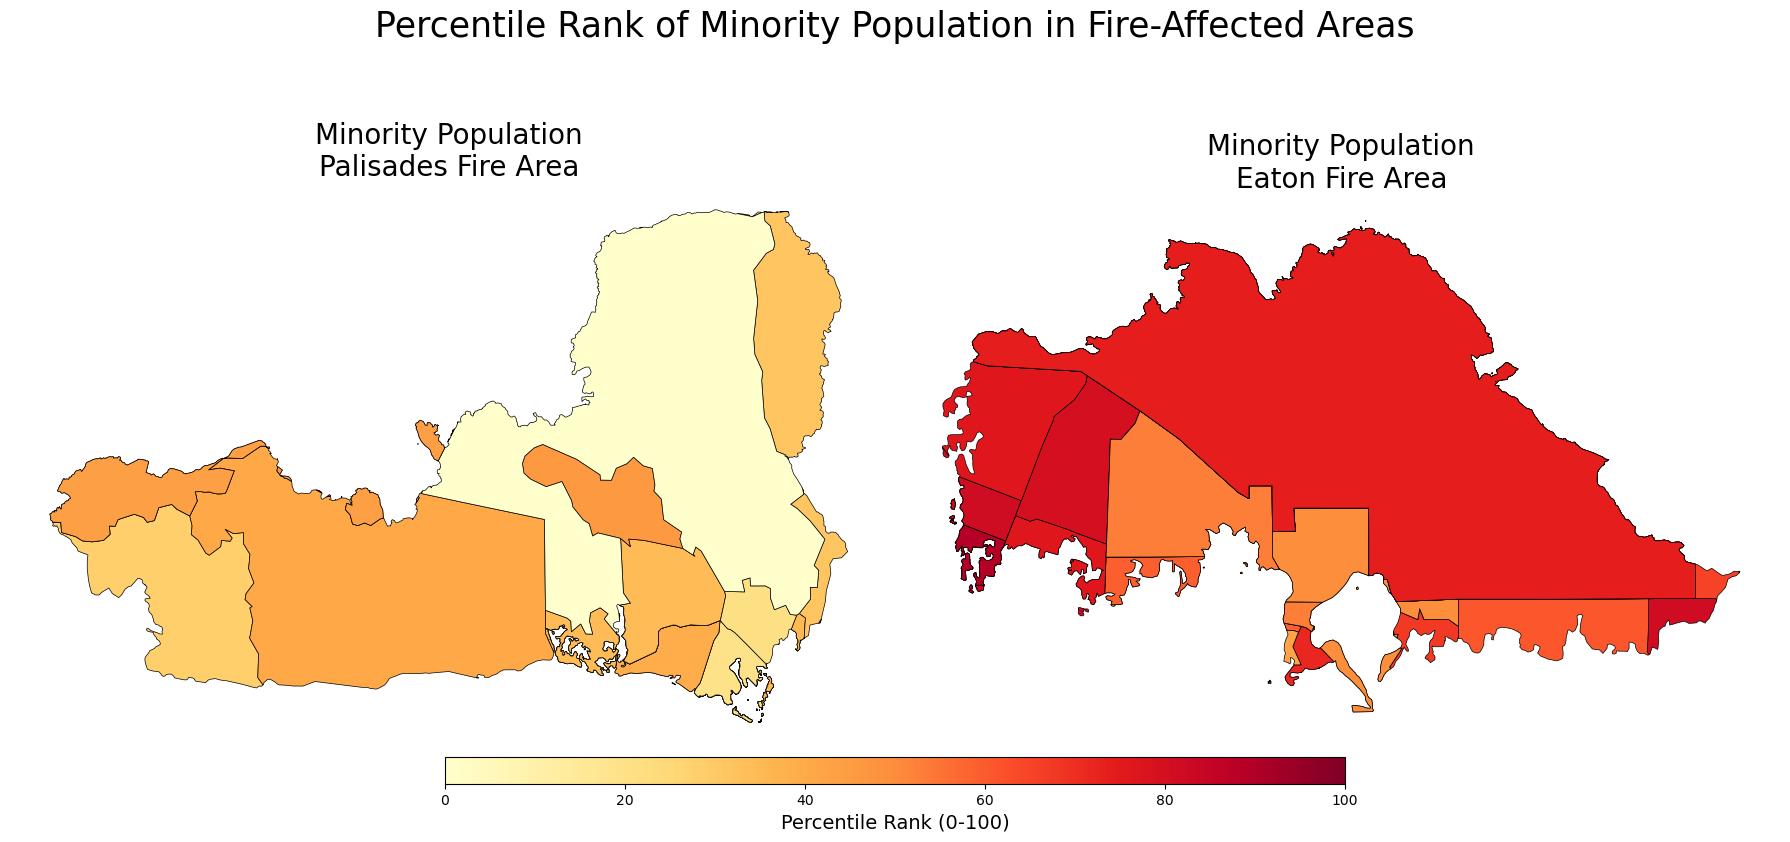

In [7]:
# Create side-by-side comparison figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Define variable to analyze
eji_variable = 'EPL_MINRTY'

# Scale values to 0-100 for proper percentile display
# The raw values are 0-1, so multiply by 100 to convert to percentile
eji_clip_palisades_scaled = eji_clip_palisades.copy()
eji_clip_eaton_scaled = eji_clip_eaton.copy()

eji_clip_palisades_scaled[eji_variable] = eji_clip_palisades[eji_variable] * 100
eji_clip_eaton_scaled[eji_variable] = eji_clip_eaton[eji_variable] * 100

# Define common scale for comparison (0-100)
vmin = 0
vmax = 100

# Palisades Fire area
eji_clip_palisades_scaled.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    legend=False,
    ax=ax1,
    edgecolor='black',
    linewidth=0.5
)
ax1.set_title('Minority Population\nPalisades Fire Area', fontsize=20)
ax1.axis('off')

# Eaton Fire area
eji_clip_eaton_scaled.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    cmap='YlOrRd',
    legend=False,
    ax=ax2,
    edgecolor='black',
    linewidth=0.5
)
ax2.set_title('Minority Population\nEaton Fire Area', fontsize=20)
ax2.axis('off')

# Overall title
fig.suptitle('Percentile Rank of Minority Population in Fire-Affected Areas',
             fontsize=25, y=0.98)

# Shared colorbar at the bottom
sm = plt.cm.ScalarMappable(
    cmap='YlOrRd',
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
cbar_ax = fig.add_axes([0.25, 0.12, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentile Rank (0-100)', fontsize=14)

plt.tight_layout()
plt.show()

## Key Findings

This analysis reveals stark racial and ethnic disparities in wildfire impacts between the two fire areas. The maps show **percentile rankings** of minority population (persons of color) within fire-affected census tracts, where higher percentile values indicate greater representation of minority residents relative to other California communities.

### Palisades Fire Area

The affected census tracts show predominantly low percentile rankings (pale yellow colors, roughly 0th-30th percentiles). The Palisades fire primarily impacted areas with **very low proportions of minority residents**—reflecting the area's demographics as a predominantly white, affluent coastal community.

### Eaton Fire Area

The burn area shows dramatically higher percentile rankings, with vast portions in the 70th-100th percentiles (dark red). Nearly the entire Eaton fire footprint, particularly around Altadena, shows the highest minority population rankings in the state. The Eaton fire overwhelmingly affected **communities of color**.

### Environmental Justice Implications

This stark geographic pattern reveals that wildfire impacts are deeply tied to historical patterns of segregation and structural inequality. Communities of color—who already face compounded environmental burdens, reduced access to resources, and barriers to recovery—bore the brunt of the Eaton fire's destruction. This disparity is critical for:

- **Emergency response** - ensuring equitable resource distribution during active disasters
- **Recovery assistance** - directing aid to communities facing systemic barriers to rebuilding
- **Long-term planning** - addressing how climate disasters compound existing racial inequities

### Statistical Context

While both fires burned similar geographic areas, the socioeconomic profiles of affected communities differ dramatically:

- The Palisades Fire affected predominantly low percentile minority population tracts
- The Eaton Fire affected predominantly high percentile minority population tracts (70th-100th)
- This pattern suggests that communities of color bore a disproportionate burden of wildfire impacts in this disaster

## Conclusion

This spatial analysis demonstrates how integrating fire perimeter data with census-based environmental justice indicators can reveal critical disparities in who bears the burden of climate disasters. The stark contrast between the Palisades and Eaton fires—with Eaton disproportionately affecting communities of color while Palisades primarily impacted wealthier, predominantly white neighborhoods—underscores the unequal distribution of climate disaster impacts.

Communities with higher minority population percentile rankings often face compounded challenges:

- Limited financial reserves for evacuation and temporary housing
- Reduced access to insurance and recovery resources
- Barriers to navigating recovery bureaucracy
- Historical disinvestment and environmental burdens

The combination of `geopandas` spatial operations—including spatial joins (`sjoin`), geometric clipping (`clip`), and coordinate system management (`to_crs`)—provides a robust Python-based workflow for this critical environmental justice analysis. By processing fire boundaries alongside census-based vulnerability data, we can identify not just where fires burned, but whose communities bore the burden.

As climate change drives increased wildfire frequency and intensity across California and the Western United States, these integrated analytical approaches become indispensable tools for disaster response, recovery planning, and climate justice advocacy. Making both the physical and social dimensions of wildfire impacts visible empowers decision-makers to support vulnerable communities more effectively and challenges us to address the structural inequities that make some populations disproportionately vulnerable to environmental disasters.